Data is generated!


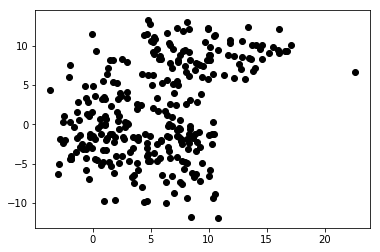

In [49]:
"""K-means Clustering
    1. Set K
    2. Clustering
    3. Updating : based on result of 2nd stage"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성
# 300개의 데이터
obs = 300     
data = []
# 정규 분포 이용 -> 3덩어리 by dispersion
for i in range(obs):
    choice = np.random.random()
    if choice < 1/3:
        x = np.random.normal(1.0,2.0)
        y = np.random.normal(-1.0,3.5)
    elif choice < 2/3:
        x = np.random.normal(9.0, 4.0)
        y = np.random.normal(9.0, 2.0)
    else:
        x = np.random.normal(7.0, 2.0)
        y = np.random.normal(-3.0, 4.0)

    plt.plot(x, y, 'ko')        # ko = black dot
    data.append([x, y])

print("Data is generated!")
plt.show()



In [50]:
K=3

# constant tensor <- data
vectors = tf.constant(data)
# Randomly pick K centroids
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors),[0, 0],[K, -1]))

In [51]:
print (vectors.get_shape())
print (centroids.get_shape())

(300, 2)
(3, 2)


In [52]:
# Comparing distance
# Dim. expansion
'''뺄셈 하려고 하는 두 텐서가 모두 2차원이지만 1차원 배열의 갯수 (D0 : 2000 vs 4) 다름.
tf.expand_dims 함수를 사용, 차원을 추가. 2차원 -> 3차원으로 만들어 뺄셈 할 수 있도록 사이즈 통일.'''

# (300, 2), (K, 2) > (n, 300, 2), (K, n, 2)
expanded_vectors = tf.expand_dims(vectors, 0)
expanded_centroids = tf.expand_dims(centroids, 1)

In [53]:
'''텐서플로우의 브로드캐스팅(broadcasting) : 
tf.subtract 함수는 두 텐서의 각 엘리먼트를 어떻게 빼야할 지 스스로 
알아낼 수 있다. 두 텐서의 구조가 같은 부분, 즉 어떤 차원이 같은 크기인지 
알아채어 해당 차원에서 뺄셈. 
대신 차원 D0는 expanded_centroids 에서만 크기가 정해져 있다.
이런 경우 텐서플로우는 expanded_vectors 텐서의 D0 차원의 크기가 
expanded_centroids의 D0 차원의 크기와 같다고 가정, 각 엘리먼트 별로 뺄셈.
expanded_centroids 텐서의 D1 차원에서도 같다. 
즉 텐서플로우는 expanded_vectors 텐서의 D1 차원과 같은 사이즈로 간주.'''

print (expanded_vectors.get_shape())
print (expanded_centroids.get_shape())

# "shape = 1" : scale is not determined


(1, 300, 2)
(3, 1, 2)


In [54]:
# Loss function = RMS of errors
# 오차가 가장 작은 index를 찾음 - best centroids
loss = tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)),2)
# tf.subtract : expaned_vectors 와 expanded_centroids 를 뺀 텐서 리턴.
# (D0 차원에는 센트로이드, D1 차원에는 데이터 인덱스, D2 차원에는 x, y 값을 가진 텐서)
# tf.reduce_sum : 텐서의 차원 축소(지정된 차원을 따라 엘리먼트들을 더함), 지정된 차원(D2).
best_centroids = tf.argmin(loss, 0)
# 마지막으로 센트로이드의 선택은 지정된 차원(여기서는 센트로이드 값이 있는 D0 차원)에서 
# 가장 작은 값의 인덱스를 리턴하는 tf.argmin 으로 결정


In [55]:
# Updating centroids
# k 개의 클러스터에 속한 모든 포인트의 평균을 가지고 있는 k 개의 텐서를 합친 means 텐서
means = tf.concat([tf.reduce_mean(tf.gather(vectors, tf.reshape(tf.where( tf.equal(best_centroids, c)),[1,-1])), reduction_indices=[1]) for c in range(K)], 0)
# equal : 한 클러스터 c에 매핑되는 best_centroids 텐서의 요소에 true 주는 boolean 텐서 생성
# c : 클러스터 번호
# where : 특정 기준에 해당하는 data의 좌표 생성
'''파라미터로 받은 boolean 텐서에서 true로 표시된 위치를 값으로 가지는 텐서
(Dimension(1) x Dimension(2000)) -> [Dimension(None), Dimension(1)]'''
# reshape : tensor로 변환
'''c 클러스터에 속한 vectors 텐서의 포인트들의 인덱스로 구성된 텐서
(Dimension(2000) x Dimension(1))를 만듭니다.
(역주: reshape의 텐서의 크기를 지정하는 파라메타의 두번째 배열요소가 -1이라 
앞단계에서 만든 텐서를 차원을 뒤집는 효과를 발휘하여 [Dimension(1), Dimension(None)]'''
# gather : 특정 기준에 해당하는 data만 모은다
'''c 클러스터를 구성하는 포인트의 좌표를 모은 텐서
(Dimension(1) x Dimension(2000)) -> [Dimension(1), Dimension(None), Dimension(2)'''
# reduce_mean : 특정 기준의 data의 평균을 구한다
'''c 클러스터에 속한 모든 포인트의 평균 값을 가진 텐서(Dimension(1) x Dimension(2))'''
update_centroids = tf.assign(centroids, means)
'''means 텐서의 값을 centroids에 할당하는 연산을 만들어
 run() 메소드가 실행될 때 업데이트 된 센트로이드 값이 다음번 루프 반복에서 사용'''

'means 텐서의 값을 centroids에 할당하는 연산을 만들어\n run() 메소드가 실행될 때 업데이트 된 센트로이드 값이 다음번 루프 반복에서 사용'

In [56]:
# Run tf
# 데이터 그래프 실행시키기 전 모든 변수를 초기화
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

In [57]:
# Training
'''매 반복마다 센트로이드가 업데이트 되고 각 포인트가 새로운 클래스에 할당
코드에서 지정한 세개의 연산은 run() 함수가 호출되면 지정한 순서대로 실행. 
sess.run() 은 훈련 과정동안 세개의 연산에 상응하는 텐서 세개를 numpy 배열로 만들어 리턴
update_centroides 연산은 리턴 값이 없으므로 '_' 버림 변수를 지정해 제외'''
for step in range(1):
    _ , centroid_values, assignment_values = sess.run([update_centroids, centroids, best_centroids])
#    print("Iter : ",step)
#print("Training is done!")

In [58]:
print (centroid_values)     # [x,y]

[[ 11.05569553   8.41957951]
 [  3.77207708  -2.19650388]
 [  3.85521412   8.64371777]]


Plotting 완료


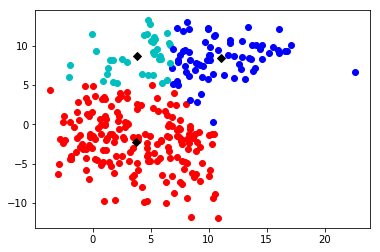

In [59]:
# Labelling data
for i in range(len(assignment_values)):
    if assignment_values[i] == 0:
        plt.plot(data[i][0],data[i][1], 'bo')
    elif assignment_values[i] == 1:
        plt.plot(data[i][0], data[i][1], 'ro')
    elif assignment_values[i] == 2:
        plt.plot(data[i][0], data[i][1], 'co')
    else:
        plt.plot(data[i][0], data[i][1], 'go')
        
plt.plot(centroid_values[:,0], centroid_values[:,1], 'kD')  

print("Plotting 완료")
plt.show()

